<a href="https://colab.research.google.com/github/oghzzang/tutorial/blob/phd/230223_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.model_selection import LeaveOneOut, cross_val_score, StratifiedKFold
from sklearn.metrics import auc, plot_roc_curve, confusion_matrix, accuracy_score, roc_curve
import pickle
import joblib
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from sklearn import preprocessing
import pandas
import seaborn

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_wine

from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
print(sklearn.__version__)

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import random
random.seed(300)


1.0.2


# 1. 데이터셋 불러오기

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/co_mitochondria/12.prediction model (n=180).csv')

data.head()

,obs,patient_no,subject_no,sample_barcode,group,sample_YY,sex,batch,dm,htn,...,mtcn_2,mtcn_3,time_points,min_year,max_year,min_bxyear,updrs_ii_mean,updrs_iii_mean,updrs_ii_iii_mean,updrs_ii_iii_group
0,179,59493635,P0412,P0412,pd,2020,2,second pd,1,1,...,1,1,1,2020,2020,0,24.000000,49.000000,73.000000,2
1,142,50290101,P0288,KBB00004393,pd,2019,2,batch 2,1,0,...,1,1,2,2019,2020,0,6.500000,35.000000,41.500000,2
2,24,51572192,P0201,KBB00002159,pd,2016,1,batch 1,0,1,...,1,1,3,2016,2019,0,4.500000,33.000000,37.500000,2
3,173,44625997,P0349,P0349,pd,2020,1,second pd,0,0,...,1,1,1,2020,2020,0,5.000000,42.000000,47.000000,2
4,134,53389459,P0368,P0368,pd,2020,1,second pd,0,0,...,1,1,4,2017,2021,-3,4.666667,17.666667,22.333333,1


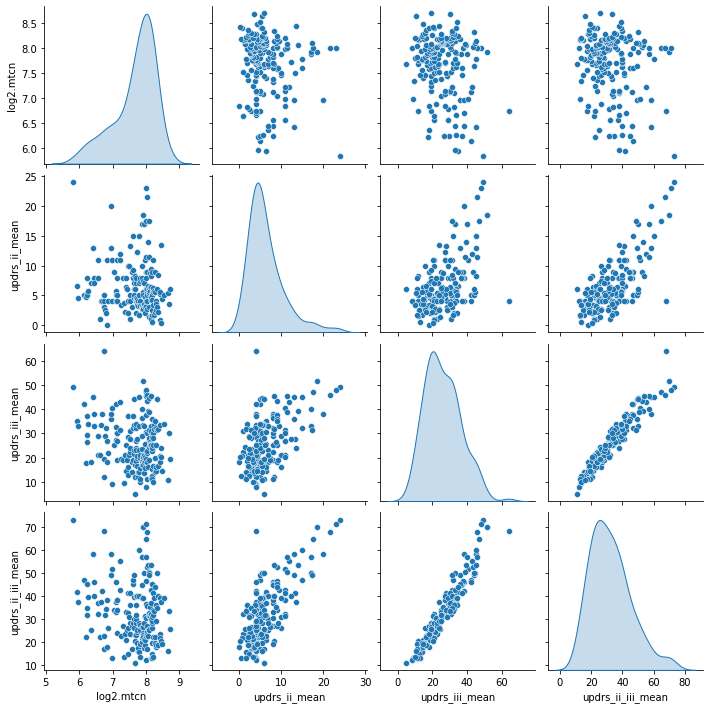

In [ ]:
seaborn.pairplot(data[["log2.mtcn", "updrs_ii_mean", "updrs_iii_mean", "updrs_ii_iii_mean"]], 
                 diag_kind = "kde")

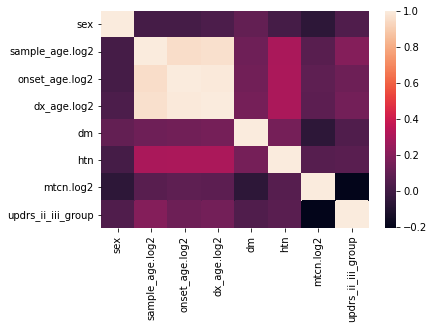

In [ ]:
data = data[['sex', 'sample_age', 
             'onset_age', 'dx_age',
             'dm', 'htn',
             'mtcn', 'updrs_ii_iii_group']]


#encoder_ordinal = preprocessing.OrdinalEncoder()
data['sex'] = data['sex'].astype('category')
data['updrs_ii_iii_group'] = data['updrs_ii_iii_group'].astype('category')
data['dm'] = data['dm'].astype('category')
data['htn'] = data['htn'].astype('category')

data['mtcn.log2'] = np.log2(data['mtcn'])
data['sample_age.log2'] = np.log2(data['sample_age'])
data['onset_age.log2'] = np.log2(data['onset_age'])
data['dx_age.log2'] = np.log2(data['dx_age'])

data = data[['sex', 
             'sample_age.log2', 
             'onset_age.log2', 
             'dx_age.log2',
             'dm', 'htn',
             'mtcn.log2', 'updrs_ii_iii_group']]

#data['mtcn_3'] = data['mtcn_3'].astype('category')


cols = data.columns
num_cols = data._get_numeric_data().columns
categorical_cols = list(set(cols) - set(num_cols))

lbl_encode = LabelEncoder()
for i in categorical_cols:
    num = data.columns.get_loc(i)
    data.iloc[:,num] = lbl_encode.fit_transform(data.iloc[:,num])

#data['updrs_ii_iii_group'] = encoder_ordinal.fit_transform(data[['updrs_ii_iii_group']])


corr = data.corr()
sns.heatmap(corr)

- 변수간에 높은 correlation 을 보이는 feature는 제외함. 

In [ ]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = data.columns[columns]
data = data[selected_columns]
data

,sex,sample_age.log2,dm,htn,mtcn.log2,updrs_ii_iii_group
0,1,6.285402,1,1,5.822701,1
1,1,6.000000,1,0,5.924114,1
2,0,6.066089,0,1,5.961564,1
3,0,6.000000,0,0,6.130713,1
4,0,5.523562,0,0,6.206385,0
...,...,...,...,...,...,...
175,0,6.108524,1,0,8.492410,0
176,0,6.129283,0,1,8.539976,1
177,0,5.584963,0,0,8.644584,0
178,0,6.044394,0,0,8.688077,1


- 결과변수 : updrs_ii_iii_group
- 설명변수 : sex, sample_age (log2), dm, htn, mtcn (log2)

# 2. Split data for tuning hyperparameters

## 1) 전체 180명의 데이터를 training set 80%, test set 20%로 분리함

=> Q. 데이터 수가 적은 경우에 이정도 비율로 분리해서 사용하는게 적합할지??

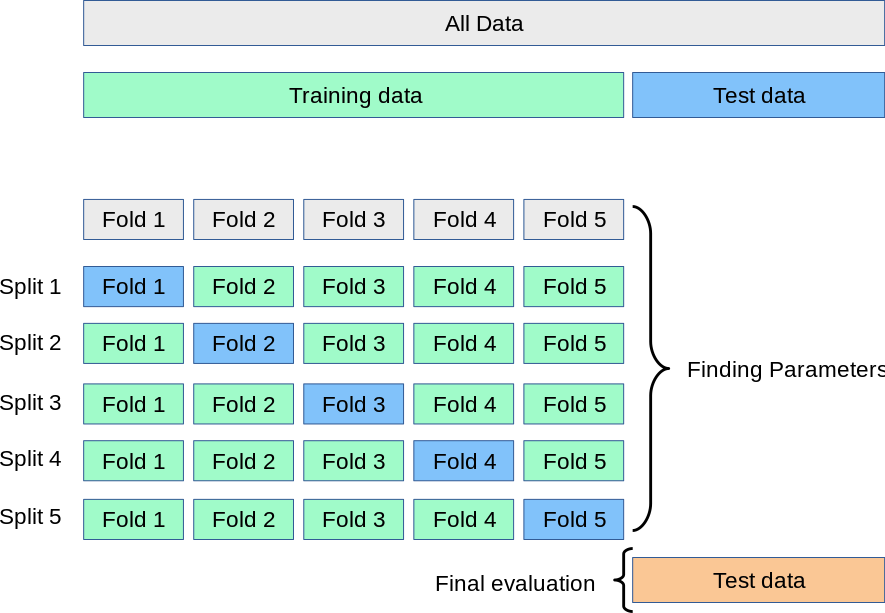

In [ ]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    shuffle=True, stratify=y,
                                                    random_state = 100)

## 2) RandomizedSearchCV를 사용하여 hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

rfc = RandomForestClassifier(random_state = 100)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

## 3) 최적의 parameter 찾기

In [ ]:
y_train.value_counts()
y_test.value_counts()

0    18
1    18
Name: updrs_ii_iii_group, dtype: int64

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 30)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 50, num = 25)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = range(1,40)

# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,40)

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [3,
               4,
               6,
               8,
               10,
               12,
               14,
               16,
               18,
               20,
               22,
               24,
               26,
               28,
               30,
               32,
               34,
               36,
               38,
               40,
               42,
               44,
               46,
               48,
               50,
               None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': range(1, 40),
 'min_samples_split': range(1, 40),
 'n_estimators': [10,
                  20,
                  30,
                  40,
                  50,
                  60,
                  70,
                  80,
                  90,
                  100,
                  110,
                  120,
                  130,
                  140,
                  150,
                  160,

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               verbose=2, 
                               random_state=100, n_jobs = -1)

In [ ]:
# Fit the random search model 모델 훈련
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24, 26,
                                                      28, 30, 32, 34, 36, 38,
                                                      40, 42, 44, 46, 48, 50,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': range(1, 40),
                                        'min_samples_split': range(1, 40),
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
  

## 4) randomizedSearchCV로 찾은 최적의 hyperparameter를 확인하기

In [ ]:
print('최적 하이퍼파라미터: ', rf_random.best_params_)
print('검증 정확도:', rf_random.best_score_)

최적 하이퍼파라미터:  {'n_estimators': 240, 'min_samples_split': 36, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
검증 정확도: 0.6118226600985222


## 5) 최적의 hyperparameter로 모델 만들기

In [ ]:
rf_best = RandomForestClassifier(n_estimators=rf_random.best_params_['n_estimators'],
                                  max_features=rf_random.best_params_['max_features'],
                                  max_depth=rf_random.best_params_['max_depth'],
                                  min_samples_split=rf_random.best_params_['min_samples_split'],
                                  min_samples_leaf=rf_random.best_params_['min_samples_leaf'],
                                  bootstrap=rf_random.best_params_['bootstrap'],
                                  verbose=2, 
                                  random_state=100, n_jobs = -1)

## 6) 기본 모델과 비교하기

- base model (rf)
- tuned moel (rf_best)

In [ ]:
rf = RandomForestClassifier(random_state = 100)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print(f"기본 모델 성능: {rf_score}")
print("Accuracy: {:.2f}%".format(rf_accuracy*100))
print("F1 score: {:.2f}".format(rf_f1))

##--
rf_best.fit(X_train, y_train)
rf_best_score = rf_best.score(X_test, y_test)
rf_best_pred = rf_best.predict(X_test)
print(f"튜닝한 모델 성능: {rf_best_score}")
rf_best_accuracy = accuracy_score(y_test, rf_best_pred)
rf_best_f1 = f1_score(y_test, rf_best_pred)

print("Accuracy: {:.2f}%".format(rf_best_accuracy*100))
print("F1 score: {:.2f}".format(rf_best_f1))

#print('검증 정확도:', base_model.score(X_test, y_test))
#y_test_pred = base_model.predict(X_test)
#print('F1:', f1_score(y_test, y_test_pred))

기본 모델 성능: 0.5555555555555556
Accuracy: 55.56%
F1 score: 0.56
building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240building tree 7 of 240

building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240building tree 22 of 240

building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tre

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s


building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82 of 240
building tree 83 of 240
building tree 84 of 240
building tree 85 of 240
building tree 86 of 240
building tree 87 of 240
building tree 88 of 240
building tree 89 of 240
building tree 90 of 240
building tree 91 of 240
building tree 92 of 240building tree 93 of 240

building tree 94 of 240
building tree 95 of 240
building tree 96 of 240
building tree 97 of 240
building tree 98 of 240
building tree 99 of 240
building tree 100 of 240
building tree 101 of 240
building tree 102 of 240building tree 103 of 240

building tree 104 of 240
building tree 105 of 240
building tree 106 of 240
building tree 107 of 240
building tree 108 of 240
building tree 109 of 240
building tree 110 of 240
building tree 111 of 240
building tree 112 of 240
building tree 113 of 240building tree 114 of 240
building tree 115 of 240

building tree 116 of 240
building tree 117 of 240
building tree 118 of 2

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.




building tree 202 of 240building tree 203 of 240
building tree 204 of 240
building tree 205 of 240
building tree 206 of 240
building tree 207 of 240
building tree 208 of 240
building tree 209 of 240

building tree 210 of 240building tree 211 of 240

building tree 212 of 240building tree 213 of 240

building tree 214 of 240building tree 215 of 240

building tree 216 of 240
building tree 217 of 240
building tree 218 of 240
building tree 219 of 240building tree 220 of 240

building tree 221 of 240
building tree 222 of 240
building tree 223 of 240
building tree 224 of 240
building tree 225 of 240
building tree 226 of 240
building tree 227 of 240
building tree 228 of 240
building tree 229 of 240
building tree 230 of 240
building tree 231 of 240
building tree 232 of 240
building tree 233 of 240
building tree 234 of 240
building tree 235 of 240
building tree 236 of 240building tree 237 of 240

building tree 238 of 240
building tree 239 of 240
building tree 240 of 240
튜닝한 모델 성능: 0.6388888888

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.1s finished


# 선정한 하이퍼 파라미터를 이용해서 RandomForest 수행하기

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score
from sklearn.model_selection import KFold, cross_val_predict

# Perform 5-fold cross validation using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=100)
accuracy_scores = []
auc_scores = []
sensitivity_scores = []
specificity_scores = []
ppv_scores = []
important_features = []

for train_index, test_index in cv.split(X):
    # Split data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model on training data
    rf_best.fit(X_train, y_train)
    
    # Make predictions on testing data
    y_pred = rf_best.predict(X_test)
    
    # Calculate metrics for this fold
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity_scores.append(tp / (tp + fn))
    specificity_scores.append(tn / (tn + fp))
    ppv_scores.append(tp / (tp + fp))
    important_features.append(rf_best.feature_importances_)

# Print the mean evaluation metrics across all folds
print('Cross validated accuracy:', np.mean(accuracy_scores))
print('Cross validated accuracy (std):', np.std(accuracy_scores))
print('Cross validated AUC:', np.mean(auc_scores))
print('Cross validated AUC (std):', np.std(auc_scores))
print('Cross validated sensitivity:', np.mean(sensitivity_scores))
print('Cross validated sensitivity (std):', np.std(sensitivity_scores))
print('Cross validated specificity:', np.mean(specificity_scores))
print('Cross validated specificity (std):', np.std(specificity_scores))
print('Cross validated PPV:', np.mean(ppv_scores))
print('Cross validated PPV (std):', np.std(ppv_scores))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240building tree 8 of 240

building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240building tree 13 of 240
building tree 14 of 240
building tree 15 of 240

building tree 16 of 240building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240

building tree 25 of 240building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240

building tree 31 of 240
building tree 32 of 240
building tree 33 of 240building tree 34 of 240
building tree 35 of 240
building tree 36 of 240

building tree 37 of 240
building tree 38 of 240
building tree 39 of 240building tree 40 of 240

building tree 41 of 240
building tree 42 of 240
b

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s


building tree 225 of 240
building tree 226 of 240
building tree 227 of 240
building tree 228 of 240building tree 229 of 240

building tree 230 of 240
building tree 231 of 240
building tree 232 of 240
building tree 233 of 240
building tree 234 of 240building tree 235 of 240

building tree 236 of 240
building tree 237 of 240
building tree 238 of 240
building tree 239 of 240
building tree 240 of 240


[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240building tree 4 of 240

building tree 5 of 240
building tree 6 of 240
building tree 7 of 240building tree 8 of 240

building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240building tree 20 of 240

building tree 21 of 240
building tree 22 of 240building tree 23 of 240

building tree 24 of 240
building tree 25 of 240building tree 26 of 240

building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240
building tree 41 of 240
building tree 42 of 240bu

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.3s


building tree 123 of 240
building tree 124 of 240
building tree 125 of 240
building tree 126 of 240
building tree 127 of 240
building tree 128 of 240
building tree 129 of 240
building tree 130 of 240
building tree 131 of 240
building tree 132 of 240
building tree 133 of 240
building tree 134 of 240
building tree 135 of 240building tree 136 of 240

building tree 137 of 240
building tree 138 of 240
building tree 139 of 240
building tree 140 of 240
building tree 141 of 240
building tree 142 of 240
building tree 143 of 240
building tree 144 of 240
building tree 145 of 240
building tree 146 of 240
building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240
building tree 153 of 240building tree 154 of 240

building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240
building tree 161 of 240
building tree 162 of 240


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240building tree 5 of 240

building tree 6 of 240
building tree 7 of 240building tree 8 of 240

building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240building tree 25 of 240
building tree 26 of 240

building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240
building tree 41 of 240
building tree 42 of 240
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.2s


building tree 137 of 240
building tree 138 of 240building tree 139 of 240

building tree 140 of 240
building tree 141 of 240
building tree 142 of 240
building tree 143 of 240
building tree 144 of 240
building tree 145 of 240
building tree 146 of 240
building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240building tree 153 of 240

building tree 154 of 240
building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240
building tree 161 of 240
building tree 162 of 240
building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240building tree 167 of 240

building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240building tree 175 of 240

building tree 176 of 240


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240building tree 7 of 240

building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240building tree 14 of 240

building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240building tree 38 of 240

building tree 39 of 240
building tree 40 of 240
building tree 41 of 240
building tree 42 of 240
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.3s


building tree 127 of 240building tree 128 of 240
building tree 129 of 240

building tree 130 of 240
building tree 131 of 240building tree 132 of 240

building tree 133 of 240
building tree 134 of 240
building tree 135 of 240
building tree 136 of 240
building tree 137 of 240
building tree 138 of 240
building tree 139 of 240
building tree 140 of 240
building tree 141 of 240
building tree 142 of 240
building tree 143 of 240
building tree 144 of 240
building tree 145 of 240building tree 146 of 240

building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240
building tree 153 of 240
building tree 154 of 240
building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240building tree 161 of 240

building tree 162 of 240
building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240b

[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 240building tree 2 of 240

building tree 3 of 240
building tree 4 of 240
building tree 5 of 240building tree 6 of 240

building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240building tree 14 of 240
building tree 15 of 240

building tree 16 of 240building tree 17 of 240

building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240building tree 31 of 240

building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240building tree 41 of 240

building tree 42 of 240
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s


building tree 96 of 240
building tree 97 of 240
building tree 98 of 240
building tree 99 of 240
building tree 100 of 240
building tree 101 of 240
building tree 102 of 240
building tree 103 of 240
building tree 104 of 240
building tree 105 of 240
building tree 106 of 240
building tree 107 of 240
building tree 108 of 240
building tree 109 of 240
building tree 110 of 240
building tree 111 of 240
building tree 112 of 240
building tree 113 of 240
building tree 114 of 240
building tree 115 of 240
building tree 116 of 240
building tree 117 of 240
building tree 118 of 240
building tree 119 of 240
building tree 120 of 240
building tree 121 of 240
building tree 122 of 240building tree 123 of 240

building tree 124 of 240
building tree 125 of 240
building tree 126 of 240
building tree 127 of 240
building tree 128 of 240
building tree 129 of 240
building tree 130 of 240
building tree 131 of 240building tree 132 of 240

building tree 133 of 240
building tree 134 of 240
building tree 135 of 240
buil

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.0s finished



building tree 221 of 240building tree 222 of 240
building tree 223 of 240
building tree 224 of 240
building tree 225 of 240

building tree 226 of 240
building tree 227 of 240
building tree 228 of 240building tree 229 of 240

building tree 230 of 240
building tree 231 of 240
building tree 232 of 240
building tree 233 of 240
building tree 234 of 240
building tree 235 of 240
building tree 236 of 240
building tree 237 of 240
building tree 238 of 240
building tree 239 of 240building tree 240 of 240

Cross validated accuracy: 0.6333333333333334
Cross validated accuracy (std): 0.11027462911821782
Cross validated AUC: 0.6294141492322607
Cross validated AUC (std): 0.10889570450471715
Cross validated sensitivity: 0.698477421271539
Cross validated sensitivity (std): 0.09023617182408873
Cross validated specificity: 0.5603508771929825
Cross validated specificity (std): 0.15505675645509975
Cross validated PPV: 0.6255134464853135
Cross validated PPV (std): 0.12666875110302042


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend L

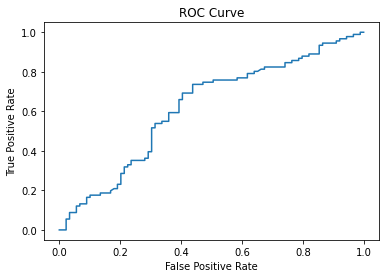

dm 0.002917148666334672
htn 0.029474542466854346
sex 0.03914525636335033
sample_age.log2 0.4516031479914494
mtcn.log2 0.4768599045120112


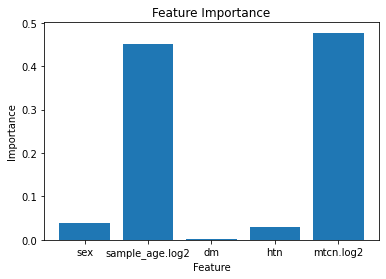

In [ ]:
# Plot ROC curve

y_pred_prob = cross_val_predict(rf_best, X, y, cv=cv, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
#plt.savefig("/content/drive/My Drive/Colab Notebooks/co_mitochondria/14.prediction.roc.pdf")


# Print feature importances
mean_importances = np.mean(important_features, axis=0)
feature_names = X.columns
sorted_idx = mean_importances.argsort()
for i in sorted_idx:
    print(feature_names[i], mean_importances[i])

plt.bar(X.columns, mean_importances)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
#plt.savefig("/content/drive/My Drive/Colab Notebooks/co_mitochondria/14.prediction.feature.pdf")

In [ ]:
saved_model = pickle.dumps(rf_best)
saved_model

joblib.dump(rf_best, '/content/drive/My Drive/Colab Notebooks/co_mitochondria/14.prediction_rf_best.pkl')

['/content/drive/My Drive/Colab Notebooks/co_mitochondria/14.prediction_rf_best.pkl']

- mtcn 이 가장 중요한 feature 
- AUC = 0.63 +/- 0.11